<a href="https://colab.research.google.com/github/tomunizua/linear_regression_model/blob/master/summative/linear_regression/multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries

import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

Load the dataset

In [2]:
df = pd.read_csv('dataset/test.csv')
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City
0,0x2318,COIMBRES13DEL01,NaN,NaN,11.003669,76.976494,11.043669,77.016494,30-03-2022,NaN,15:05:00,conditions NaN,NaN,3,Drinks,electric_scooter,1,No,Metropolitian
1,0x3474,BANGRES15DEL01,28,4.6,12.975377,77.696664,13.085377,77.806664,29-03-2022,20:30:00,20:35:00,conditions Windy,Jam,0,Snack,motorcycle,1,No,Metropolitian
2,0x9420,JAPRES09DEL03,23,4.5,26.911378,75.789034,27.001378,75.879034,10-03-2022,19:35:00,19:45:00,conditions Stormy,Jam,0,Drinks,motorcycle,1,No,Metropolitian
3,0x72ee,JAPRES07DEL03,21,4.8,26.766536,75.837333,26.856536,75.927333,02-04-2022,17:15:00,17:20:00,conditions Fog,Medium,1,Meal,scooter,1,No,Metropolitian
4,0xa759,CHENRES19DEL01,31,4.6,12.986047,80.218114,13.096047,80.328114,27-03-2022,18:25:00,18:40:00,conditions Sunny,Medium,2,Drinks,scooter,1,No,Metropolitian


Pre-processing

In [3]:
# Forward fill missing values
df.ffill(inplace=True)

# Drop rows with NaN values in columns
df.dropna(inplace=True)

# Remove the word 'condition' from the 'Weatherconditions' values
df['Weatherconditions'] = df['Weatherconditions'].str.replace('conditions ', '', regex=False)

# Convert to datetime format and create time-based features
df['Order_Date'] = pd.to_datetime(df['Order_Date'], dayfirst=True)
df['hour'] = pd.to_datetime(df['Time_Order_picked'], format='%H:%M:%S').dt.hour
df['day_of_week'] = df['Order_Date'].dt.dayofweek
df['order_date'] = df['Order_Date'].dt.date

# Calculate demand by date and hour
demand = df.groupby(['order_date', 'hour']).size().reset_index(name='demand')

# Merge the demand indicator back into the original dataframe
df = pd.merge(df, demand, on=['order_date', 'hour'])

# Drop columns that still have NaN values after merging
df.dropna(axis=1, inplace=True)

# Define categorical and numerical features
categorical_features = ['Weatherconditions', 'Road_traffic_density', 'Type_of_order', 'Festival', 'City']
numerical_features = ['hour', 'day_of_week', 'multiple_deliveries']

# Prepare the data

columns_to_drop = ['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)',
                   'Restaurant_latitude', 'Restaurant_longitude', 'Time_Orderd', 'Vehicle_condition', 'Type_of_vehicle',
                   'Order_Date', 'Time_Order_picked',  'Delivery_location_latitude', 'Delivery_location_longitude', '']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=columns_to_drop)

# Drop any remaining NaN columns
df = df.dropna(axis=1, how='any')

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

X = df[[
    'Weatherconditions', 'Road_traffic_density', 'Type_of_order',
    'multiple_deliveries', 'Festival', 'City', 'hour', 'day_of_week']]
y = df['demand']

X = preprocessor.fit_transform(X)

processed_df = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

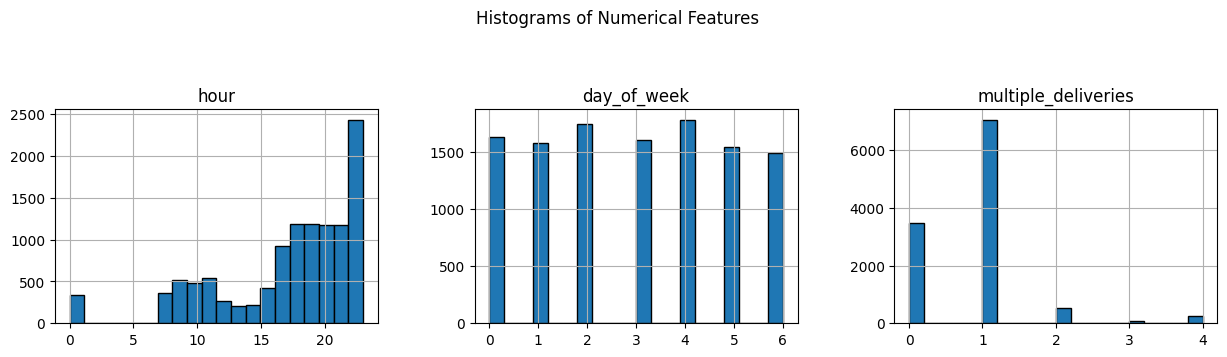

In [ ]:
# Visualization 1: Histogram

df[numerical_features].hist(bins=20, figsize=(15, 10), layout=(3, 3), edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

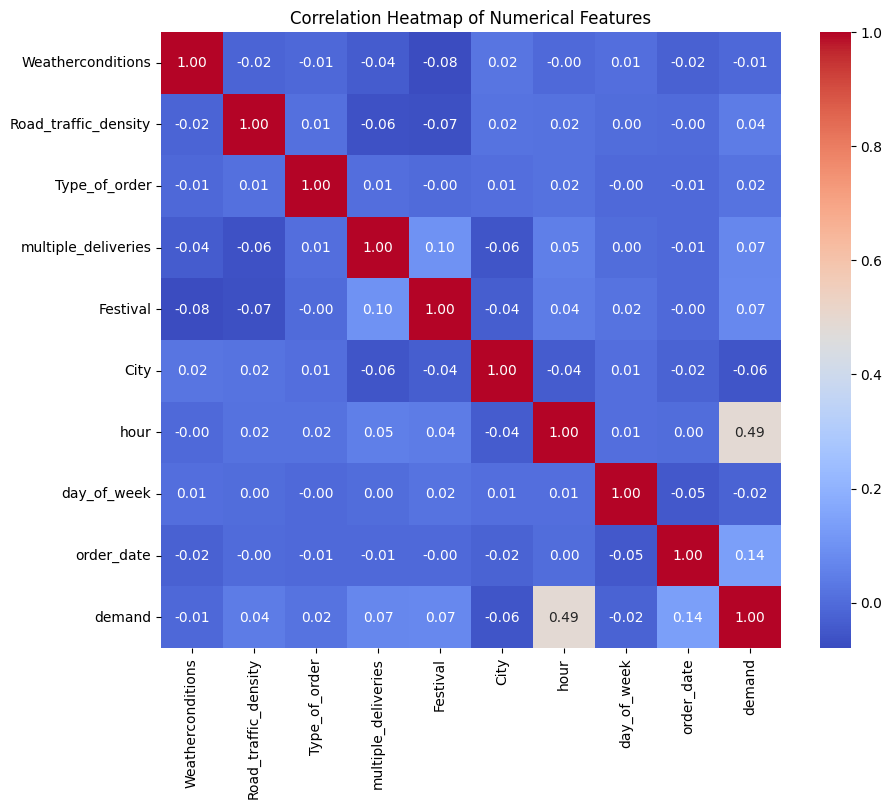

In [6]:
# Visualization 2: correlation heatmap
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


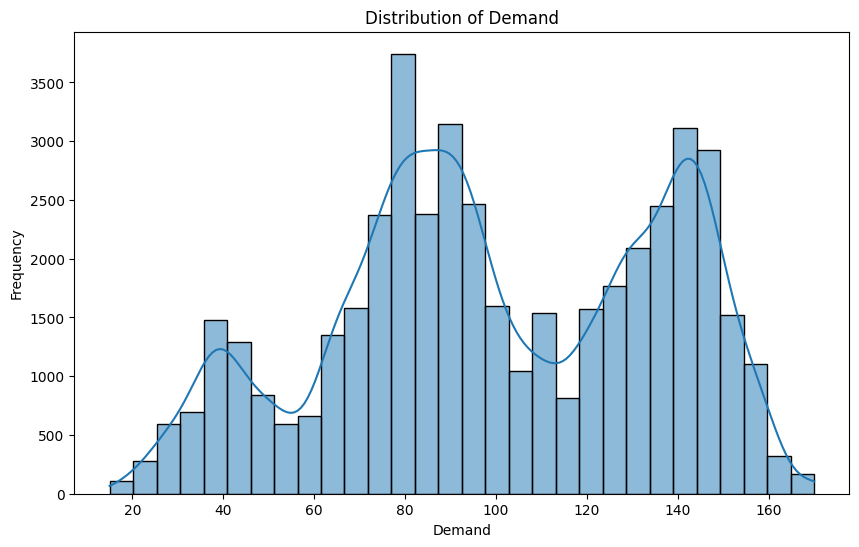

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['demand'], bins=30, kde=True)
plt.title('Distribution of Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Check and convert data types
for col in df.columns:
   if df[col].dtype == 'object':
       df[col] = df[col].astype('category').cat.codes

# Define features (X) and target (Y)
X = df.drop('demand', axis=1)
Y = df['demand']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Verify the data types after preprocessing
print(X_train.dtypes)


Weatherconditions        int8
Road_traffic_density     int8
Type_of_order            int8
multiple_deliveries      int8
Festival                 int8
City                     int8
hour                    int32
day_of_week             int32
order_date               int8
dtype: object


In [7]:
# Initialize and train the LinearRegression model
lr_sklearn = LinearRegression()
lr_sklearn.fit(X_train, Y_train)

LinearRegression()

In [8]:
# Predict on the test set
Y_pred_lr = lr_sklearn.predict(X_test)

# Calculate the Mean Squared Error (MSE)
rmse_lr = root_mean_squared_error(Y_test, Y_pred_lr)
print('Linear Regression Mean Squared Error:', rmse_lr)

Linear Regression Mean Squared Error: 8.665940445992884


In [9]:
# Initialize and train the DecisionTreeRegressor model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, Y_train)
# Predict on the test set
Y_pred_dt = dt_model.predict(X_test)
# Calculate the Mean Squared Error (MSE)
rmse_dt = root_mean_squared_error(Y_test, Y_pred_dt)
print('Decision Tree RMSE:', rmse_dt)

Decision Tree RMSE: 0.28097574347450816


In [10]:
# Initialize and train the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, Y_train)
# Predict on the test set
Y_pred_rf = rf_model.predict(X_test)
# Calculate the Mean Squared Error (MSE)
rmse_rf = root_mean_squared_error(Y_test, Y_pred_rf)
print('Random Forest RMSE:', rmse_rf)

Random Forest RMSE: 0.2895412281645181


In [11]:
# Sorting by RMSE
model_rank = {
    'Linear Regression': rmse_lr,
    'Decision Tree': rmse_dt,
    'Random Forest': rmse_rf
}

model_rank = dict(sorted(model_rank.items(), key=lambda item: item[1]))

print("Model Ranking from best to worst performance:")
for model, rmse in model_rank.items():
    print(f"{model}: {rmse:.4f}")

Model Ranking from best to worst performance:
Decision Tree: 0.2810
Random Forest: 0.2895
Linear Regression: 8.6659


In [12]:
# Identify the best model
best_model = None
best_rmse = min(rmse_lr, rmse_dt, rmse_rf)

if best_rmse == rmse_lr:
    best_model = lr_sklearn
elif best_rmse == rmse_dt:
    best_model = dt_model
else:
    best_model = rf_model

# Save the best model to a file
joblib.dump(best_model, 'best_model.pkl')
print('Best model saved with RMSE:', best_rmse)


Best model saved with RMSE: 0.28097574347450816


In [13]:
# Load the saved model
model = joblib.load('best_model.pkl')

# Example input data (one row of the test dataset)
input_data = pd.DataFrame([X_test.iloc[0]], columns=X.columns)

# Make a prediction
prediction = model.predict(input_data)
print('Predicted Demand for one data point:', prediction)

Predicted Demand for one data point: [24.]


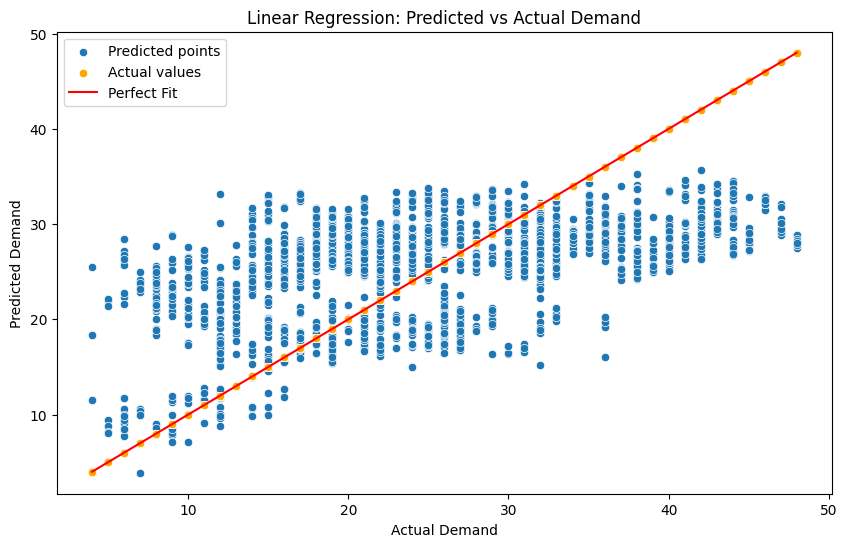

In [14]:
# Scatter plot of Actual vs Predicted values for Linear Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_test, y=Y_pred_lr, label='Predicted points')
sns.scatterplot(x=Y_test, y=Y_test, color='orange', label='Actual values')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', label='Perfect Fit')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Linear Regression: Predicted vs Actual Demand')
plt.legend()
plt.show()

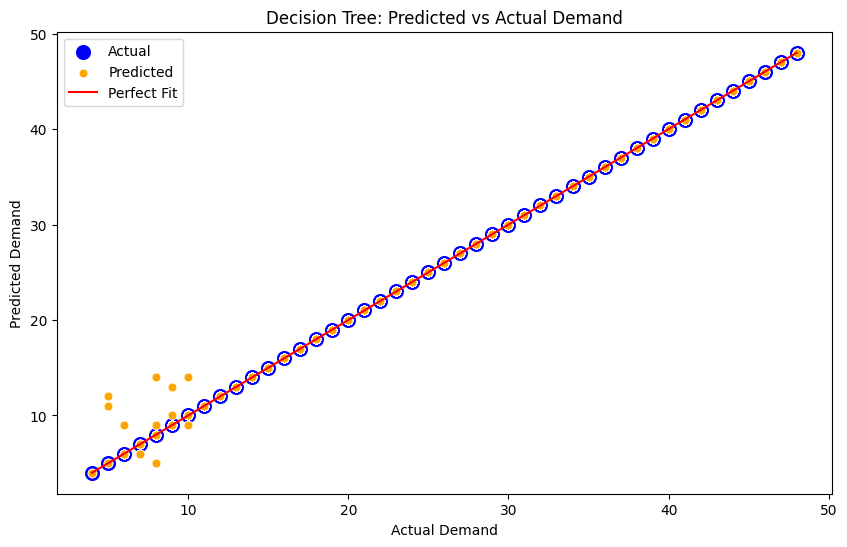

In [15]:
# Predicting on the whole test set for visualization
Y_pred_dt_full = dt_model.predict(X_test)

# Scatter plot of Actual vs Predicted values for Decision Tree
plt.figure(figsize=(10, 6))

# Actual values
sns.scatterplot(x=Y_test, y=Y_test, color='blue', label='Actual', s=140)

# Predicted values
sns.scatterplot(x=Y_test, y=Y_pred_dt_full, color='orange', label='Predicted', s=40)

plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', label='Perfect Fit')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Decision Tree: Predicted vs Actual Demand')
plt.legend()
plt.show()


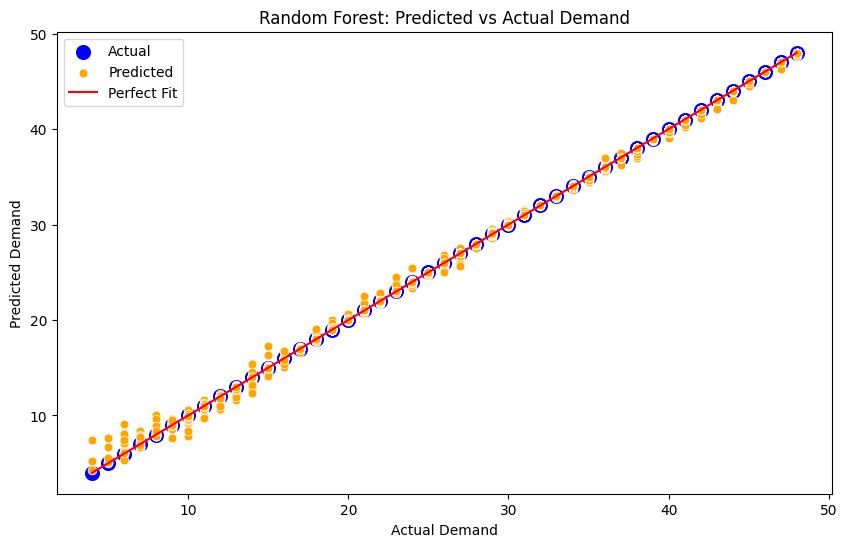

In [16]:
# Predicting on the whole test set for visualization
Y_pred_rf_full = rf_model.predict(X_test)

# Scatter plot of Actual vs Predicted values for Random Forest
plt.figure(figsize=(10, 6))

# Actual values
sns.scatterplot(x=Y_test, y=Y_test, color='blue', label='Actual', s=140)

# Predicted values
sns.scatterplot(x=Y_test, y=Y_pred_rf_full, color='orange', label='Predicted', s=40)

plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', label='Perfect Fit')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Random Forest: Predicted vs Actual Demand')
plt.legend()
plt.show()
